# Importing the necessary libraries

In [1]:
import os
from random import shuffle
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.optim import lr_scheduler
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.datasets as datasets
import time
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Defining the transforms to apply on the dataset and defining the data loader

In [2]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

In [3]:
batch_size = 64
num_workers = 2
pin_memory = True

dataset = datasets.ImageFolder(root='data/data/train', transform=data_transforms)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

dataset_val = datasets.ImageFolder(root='data/data/val', transform=data_transforms)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

dataset_test = datasets.ImageFolder(root='data/data/test', transform=data_transforms)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)


# Checking if a GPU is available, else training on CPU

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Training on {torch.cuda.get_device_name()}")
else:
    print(f"Training on CPU")

Training on CPU


# Defining the resnet 18 Model from torch vision

In [5]:
if not os.path.exists("resnet18"):
    os.mkdir("resnet18")


# Define ResNet-152 model
model = resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = True

num_classes = 4
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Defining the loss function and Optimizer as adamW
We will using a learning schedular which decays if val loss does not reduce for a few epochs

In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

# Model Training

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader
from tqdm import tqdm
import os, time

# ✅ Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# ✅ Create model save directory
os.makedirs("resnet18_fast", exist_ok=True)

# ✅ Paths to your sampled dataset
train_path = "sampled_data/train"
val_path = "sampled_data/val"

# ✅ Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ✅ Dataset and DataLoader
batch_size = 8
train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# ✅ Model setup
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model = model.to(device)

# ✅ Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ✅ Training loop
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    total_loss = 0
    start_time = time.time()

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_loss = total_loss / len(train_loader)
    elapsed = time.time() - start_time

    print(f"✅ Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%, Time: {elapsed:.2f}s")

# ✅ Save final model
torch.save(model.state_dict(), "resnet18_fast/model.pt")
print("✅ Training complete. Model saved to resnet18_fast/model.pt")


Using: cpu


Epoch 1/2: 100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


✅ Epoch 1/2 - Loss: 1.4621, Accuracy: 39.05%, Time: 95.61s


Epoch 2/2: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]

✅ Epoch 2/2 - Loss: 1.2446, Accuracy: 43.05%, Time: 87.10s
✅ Training complete. Model saved to resnet18_fast/model.pt


# Loading the best weights and evaluating on the test set

In [7]:
# Load the best model checkpoint for testing
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate the model
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 4)  # Replace 4 with your number of classes
model.load_state_dict(torch.load("resnet18_fast/model.pt"))
model = model.to(device)
model.eval()

print("✅ Model loaded and ready for evaluation.")


✅ Model loaded and ready for evaluation.


Test Loss: 1.5861, Test Accuracy: 47.11%


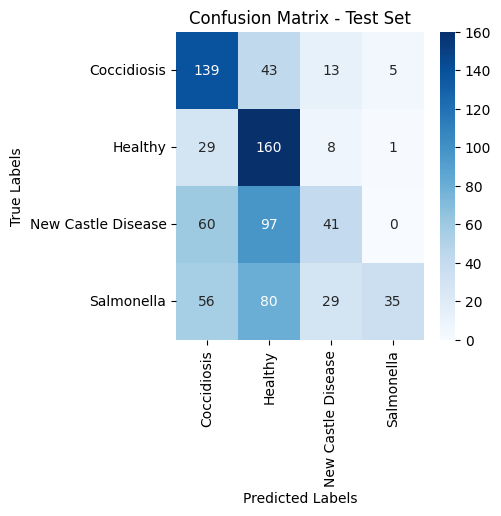

Confusion matrix saved as confusion_matrix.png


In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# ✅ Test dataset loader (add before model.eval())
test_path = "sampled_data/test"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
test_dataset = datasets.ImageFolder(test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8)

# Testing
model.eval()
class_labels = test_dataset.classes
correct_test = 0
total_test = 0
test_loss = 0.0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct_test / total_test
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Compute and plot the confusion matrix for the final test set
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(len(class_labels), len(class_labels)))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Test Set")
plt.savefig("resnet18/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()
print("Confusion matrix saved as confusion_matrix.png")

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

                    precision    recall  f1-score   support

       Coccidiosis       0.49      0.69      0.57       200
           Healthy       0.42      0.81      0.55       198
New Castle Disease       0.45      0.21      0.28       198
        Salmonella       0.85      0.17      0.29       200

          accuracy                           0.47       796
         macro avg       0.55      0.47      0.43       796
      weighted avg       0.55      0.47      0.43       796

